# Some basic setup code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import scipy.integrate as integrate
from scipy.integrate import solve_ivp

# Parametric Amplification

berggren@mit.edu, 2020-11-11

Parametric amplification is a type of amplification that has unique advantages when dealing with quantum signals.  Unlike traditional amplifiers (e.g. those we learn about in traditional electronics courses), these devices can amplify while adding a minimal amount of additional noise and fluctuations.  As such, they are incredibly useful at preserving the phase and amplitude of tiny oscillations such as those that occur in a quantum circuit.

Before we dive into quantum circuits, however, we will first consider classical parametric amplifiers.

## Classical Paramps

Consider a simple L-C circuit with an inductance (or capacitance, in principle, but most superconducting quantum paramps use inductance so we will stick with that for now) that varies in time.  This variation in time could in principle be achieved through the application of an external magnetic field that induces an external forcing current in the system.

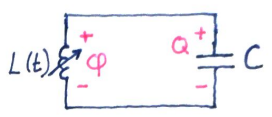

The total energy in this system (the Hamiltonian) can be written as:

$$ℋ = E_C + E_L\\
= \frac{Q^2}{2 C} + \frac{Φₒ^2}{4π^2}\frac{φ^2}{2L(t)}$$

where we draw attention now to the fact that $L$ is an explicit function of time.  We will soon choose to have $L$ be a sinusoidal function with some drive frequency, but for now let's leave things more general.

We can make our usual mechanical analog to the circuit, where we treat $φ$ as the position and $Q Φₒ / 2 π$ as the momentum, and write the energy operator (the quantum Hamiltonian operator) as:

$$\hat ℋ = \hat E_C + \hat E_L\\
= \frac{\hat Q^2}{2 C} + \frac{Φₒ^2}{4π^2}\frac{\hat φ^2}{2L(t)}.$$

### Aside on the mechanical analog:

Remebering that $\hat Q = -ħ 𝕛 ∂_Φ.$  This was our traditional mechanical momentum when our position axis was Φ.  But now we are using φ as the position axis, so the momentum operator is $ -ħ𝕛 ∂_φ = -h 𝕛 Φₒ ∂_Φ / 2π = Φₒ \hat Q / 2π ≡ Q_\text{eff}$.  This expression is a bit kludgy, and I wish we didn't have to use it, but physicists prefer using phase to fluxoid, so we're stuck with it.


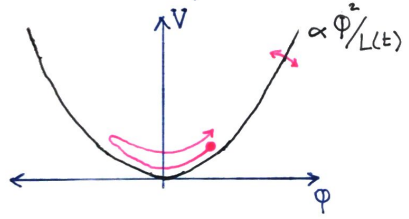

In [ ]:
ħ = 1  # h = 6.63e-34 J s or 6.58e-16 eV s
       # ħ = h / 2π = 1.05 e -34
π = np.pi
Φₒ = 1  # Φₒ = 2.07 e -15 in reality.
𝕛 = 1j

$$\newcommand{\Qeff}{Q_\text{eff}}$$
## Equations of Motion

The equations of motion (aka Hamilton's equations) can be derived from the energy function ℋ. 

$$\frac{d  φ}{dt} = - \frac{∂ℋ}{∂\Qeff}$$
$$\frac{d \Qeff}{dt} = \frac{∂ℋ}{∂φ}$$

Where $\Qeff = Q Φₒ / 2π$.  Rather than using the chain rule, we'll rewrite ℋ in terms of φ and $\Qeff$ before we apply the Hamilton's equations.

$$\hatℋ = \frac{2 π^2 \hat Q_\text{eff}^2}{C Φₒ^2} +\frac{Φₒ^2 φ^2}{8 π^2 L(t)}$$

$$\frac{d φ}{dt} = - \frac{4 π^2 Q_\text{eff}}{C Φₒ^2}\\
⇒ \frac{d φ}{dt} = -\frac{2 π Q}{Φₒ C}$$

and

$$\frac{d \Qeff}{dt} = \frac{Φₒ^2 φ}{4 π^2 L(t)}\\
⇒\frac{d Q}{dt} = \frac{Φₒ φ}{2 π L(t)}.$$

These two coupled first-order differential equations give the dynamics that define the evolution of our system.


## Constant potential test case

Before we start changing the inductance, let's just see what things look like with a constant inductance.  We should recover the conventional L-C circuit behavior.

In [ ]:
def sim(params):
  """sim: run simulation
  params: dictionary of parameters
  """
  def dvdt(t: "time", v: "Vector (φ,Q)", params):
    """ helper function for solver that gives time derivative of state.
    Note 2nd parameter is in form of a tuple as shown. """
    φ, Q = v
    C = params["C"]
    return (-2*π*Q/C/Φₒ, Φₒ*φ/2/π/params["L"](t))

  t0,t1 = params["time"]
  times = np.linspace(t0,t1,params["frames"])
  r = solve_ivp(dvdt, (t0, t1), params["v0"], t_eval = times, args=(params,))
  return r.t, r.y[0]
  
def anim(params):
  """anim: animate simulation showing potential and phase point.  In this 
  version, the potential plot does not update.

  params: dictionary of parameters
  """
  # setup
  fig = plt.figure()
  V = params["potential"]  # potential function passed as a parameter
  
  # first we need to know position of phase particle, run simulation
  times, new_data = sim(params)

  # now we need to know the potential for each time point, so we can
  # include it in the plot
  yvals = []
  for time in times:
    yvals.append(V(time, new_data, params))

  # now calculate the min and max values of the range that the system
  # actually evolves to, so we only plot the region where some action happens
  xmax = np.max(new_data)
  xmin = np.min(new_data)
  ymax = np.max(yvals)
  ymin = np.min(yvals)
  
  # some more setup
  ax = fig.add_subplot(111, xlim = (xmin, xmax), ylim = (ymin,ymax))
  particles, = ax.plot([], [], 'bo', ms=12)

  # plot the potential energy diagram
  φ_range = np.linspace(xmin, xmax, params["N"])
  ax.plot(φ_range, params["potential"](0,φ_range,params))
  ax.set_ylabel("V(φ)")
  ax.set_xlabel("phase (φ)")


  def animate(i: "index", 
              params: "parameter dictionary",
              new_data: "data from simulation",
              particles: "artists to be updated each animation step"):
      """perform animation step. Does not update potential"""
      V = params["potential"]
      data = new_data[i]
      particles.set_data([data],[params["potential"](0, data, params)])
      return particles,

  ani = animation.FuncAnimation(fig, animate, frames=params["frames"], 
                                fargs = (params, new_data, particles),
                                interval=100,
                                blit=True)
  rc('animation', html='jshtml')
  return ani

In [ ]:
params = {"min": -3, "N":200, "C":100, "time":(0,200),
          "frames":100, "v0":(0,1)}
# params controls the simulation.  Note time is a tuple of form (tmin, tmax)
# and v0 is the initial state, in form (φ, Q).

def Lfunc(t):
  """ Lfunc: return inductance.
  we are going to use this to parametrize inductance soon """
  return 1

params["L"] = Lfunc

def LC_pot(t, φ, params):
  """ LC_pot: potential for an LC circuit """
  return φ**2/2/params["L"](t)

params["potential"] = LC_pot

anim(params)

Output hidden; open in https://colab.research.google.com to view.

This looks well-behaved.  The code works.

## Example parametric drive at 2ω
Now what happens if we allow the inductance to change in time at twice the resonant frequency?  All we need to do is change Lfunc.


In [ ]:
params = {"min": -3, "N":200, "C":100, "time":(0,400),
          "frames":100, "v0":(0,1)}

def Lfunc(t):
  """ parametrized inductance, depends on time. """
  Lo = 1
  ωo = 1/np.sqrt(params["C"]*Lo)
  ωd = 2*ωo
  return Lo*(1+0.1*np.sin(ωd*t))

params["L"] = Lfunc
params["potential"] = LC_pot  # defined above

anim(params)

Output hidden; open in https://colab.research.google.com to view.

While this may appear almost magical when we look at it in a static potential, if we allow the potential to also change, it appears less magical.

In [ ]:
def anim(params):
  """anim: animate simulation showing potential and phase point.  In this 
  version, the potential plot does not update.

  params: dictionary of parameters
  """
  # setup
  fig = plt.figure()
  V = params["potential"]  # potential function passed as a parameter
  
  # first we need to know position of phase particle, run simulation
  times, new_data = sim(params)

  # now we need to know the potential for each time point, so we can
  # include it in the plot
  yvals = []
  for time in times:
    yvals.append(V(time, new_data, params))

  # now calculate the min and max values of the range that the system
  # actually evolves to, so we only plot the region where some action happens
  xmax = np.max(new_data)
  xmin = np.min(new_data)
  ymax = np.max(yvals)
  ymin = np.min(yvals)
  
  # some more setup
  ax = fig.add_subplot(111, xlim = (xmin, xmax), ylim = (ymin,ymax))
  particles, = ax.plot([], [], 'bo', ms=12)

  # plot the potential energy diagram
  φ_range = np.linspace(xmin, xmax, params["N"])
  ax.plot(φ_range, params["potential"](0,φ_range,params))
  ax.set_ylabel("V(φ)")
  ax.set_xlabel("phase (φ)")

  # set up a dynamic potential energy diagram
  pot_parts, = ax.plot([], [])

  def animate(i: "index", 
          params: "parameter dictionary",
          new_data: "data from simulation",
          particles: "artists to be updated each animation step"):
      """perform animation step, updating drawn potential each step"""
      data = new_data[i]
      time = times[i]
      particles.set_data([data],[params["potential"](i,data,params)])
      pot_parts.set_data([φ_range],[params["potential"](i,φ_range,params)])
      return particles,pot_parts

  ani = animation.FuncAnimation(fig, animate, 
                                frames=params["frames"], 
                                fargs = (params, new_data, particles),
                                interval=100,
                                blit=True)
  rc('animation', html='jshtml')
  return ani

In [ ]:
# large number of frames, so slow execution
params = {"min": -3, "N":200, "C":100, "time":(0,400),
          "frames":400, "v0":(0,1), "L":Lfunc, "potential":LC_pot}

ani = anim(params)
""" Uncomment this code if you want to save a file.
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('im.mp4', writer=writer)  # you should be able to see and download this
                                   # file from content folder: 4th icon on far
                                   # left of screen
"""
ani

Output hidden; open in https://colab.research.google.com to view.

OK, now the magic starts to reveal itself.  The blue curve is the time-averaged potential, the orange curve is the potential at each moment in time.  Every time the ball turns around, the system gives it a kick by lifting it slightly.  Whatever "finger of god" (external force) is modifying the potential is now doing work on the system, and as a result the system gains energy and the next time around, the ball ends up higher than it was on the first turn.